In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from mixedbridge.stochastic_processes.examples import CellDiffusionProcess, CellDiffusionAuxProcess
from mixedbridge.stochastic_processes.gbp import GuidedBridgeProcess, MixedGuidedBridgeProcess
from mixedbridge.baselines.pcn import PreconditionedCrankNicolson
from mixedbridge.stochastic_processes.wiener import WienerProcess
from mixedbridge.solvers.sde import Euler

2024-09-23 11:45:22.624374: W external/xla/xla/service/gpu/nvptx_compiler.cc:893] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version 12.6.68. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [3]:
dim = 2
alpha = 1. / 16.
sigma = 0.1
T = 4.0
dt = 1. / 100
dtype = jnp.float32
rng_key = jax.random.PRNGKey(42)
x0 = jnp.array([0.1, -0.1], dtype=dtype)
xT = jnp.array([2.0, -0.1], dtype=dtype)

In [4]:
wiener_process = WienerProcess(dim=dim, dtype=dtype, T=T, dt=dt)
cell_proc = CellDiffusionProcess(T=T, dt=dt, dim=dim, dtype=dtype, alpha=alpha, sigma=sigma)
cell_aux_proc = CellDiffusionAuxProcess(T=T, dt=dt, dim=dim, dtype=dtype, alpha=alpha, sigma=sigma)

L0 = jnp.eye(dim, dtype=dtype)
Sigma0 = jnp.eye(dim, dtype=dtype) * 1e-10
cell_guided_bridge_proc = GuidedBridgeProcess(L0=L0, Sigma0=Sigma0, ori_proc=cell_proc, aux_proc=cell_aux_proc, x0=x0, xT=xT)

In [5]:
key = jax.random.PRNGKey(42)
wiener_process = WienerProcess(dim=dim, dtype=dtype)

cell_guided_bridge_solver = Euler(cell_guided_bridge_proc, wiener_process)
cell_guided_bridge_path = cell_guided_bridge_solver.solve(x0=x0, dWs=None, rng_key=key, n_batches=32)

In [6]:
from flax import linen as nn
from flax.training import train_state
import optax

In [7]:
# a very simple MLP
class MLP(nn.Module):

    @nn.compact
    def __call__(self, t, x):
        t = jnp.expand_dims(t, axis=-1)
        x = jnp.concatenate([t, x], axis=-1)
        x = nn.Dense(20)(x)
        x = nn.swish(x)
        x = nn.Dense(20)(x)
        x = nn.swish(x)
        x = nn.Dense(20)(x)
        x = nn.swish(x)
        x = nn.Dense(2)(x)
        return x

In [13]:

def train_model(rng_key, model, path_solver, n_epochs, batch_size):
    rng_key, init_key = jax.random.split(rng_key)
    
    dummy_t, dummy_x = jnp.zeros((1, )), jnp.zeros((1, 2))
    params = model.init(init_key, dummy_t, dummy_x)
    optimizer = optax.sgd(1e-3)
    
    model_state = train_state.TrainState.create(
        apply_fn=model.apply,
        params=params,
        tx=optimizer
    )

    def sample_path(rng_key, path_solver):
        path = path_solver.solve(x0=x0, dWs=None, rng_key=rng_key, n_batches=batch_size)
        ts, xs, dWs = path.ts, path.xs, path.dWs
        ts = jnp.tile(jnp.expand_dims(ts, axis=0), reps=(batch_size, 1))
        return ts, xs, dWs
    
    def compute_loss(params, ts, xs, dWs, state):
        nus = state.apply_fn(params, ts, xs)
        # Gs = jax.vmap(jax.vmap(cell_guided_bridge_proc.G))(ts, xs)
        # log_lls = jnp.sum(Gs, axis=1) * dt
        inner = jax.vmap(jax.vmap(jnp.dot))(nus, dWs)
        stos = jnp.sum(inner, axis=1)
        # log_ll = jnp.mean(log_lls)
        loss = jnp.mean(stos + 0.5 *jnp.sum(jnp.linalg.norm(nus, axis=-1)**2, axis=1))
        return loss
    
    @jax.jit
    def train_step(state, ts, xs, dWs):
        grad_fn = jax.value_and_grad(compute_loss, has_aux=False)
        loss, grads = grad_fn(state.params, ts, xs, dWs, state)
        state = state.apply_gradients(grads=grads)
        return state, loss
    
    losses = []
    for epoch in range(1, n_epochs + 1):
        rng_key, batch_key = jax.random.split(rng_key)
        ts, xs, dWs = sample_path(batch_key, path_solver)
        model_state, loss = train_step(model_state, ts, xs, dWs)
        losses.append(loss)
        
        if epoch % 100 == 0:
            nu_learned = lambda t, x: model_state.apply_fn(model_state.params, t, x)
            cell_mixed_bridge_proc = MixedGuidedBridgeProcess(
                ori_proc=cell_proc,
                aux_proc=cell_aux_proc,
                nu=nu_learned,
                xT=xT,
                x0=x0,
                L0=L0,
                Sigma0=Sigma0
            )
            cell_mixed_bridge_solver = Euler(cell_mixed_bridge_proc, wiener_process)
            cell_mixed_bridge_path = cell_mixed_bridge_solver.solve(x0=x0, dWs=None, rng_key=key, n_batches=batch_size, log_likelihood=False)
            # log_ll = jnp.mean(cell_mixed_bridge_path.log_likelihood)
            print(f"Epoch {epoch}, loss: {loss}")
    return model_state, losses

In [15]:
model = MLP()
n_epochs = 1000
batch_size = 32

In [16]:
dummy_t, dummy_x = jnp.zeros((1, )), jnp.zeros((1, 2))
params = model.init(key, dummy_t, dummy_x)

In [17]:
model_state, losses = train_model(key, model, cell_guided_bridge_solver, n_epochs, batch_size)

Epoch 100, loss: -0.01990484446287155
Epoch 200, loss: -0.03380497545003891
Epoch 300, loss: -0.03434227406978607
Epoch 400, loss: -0.04095140099525452
Epoch 500, loss: -0.03995995968580246
Epoch 600, loss: -0.04616255313158035
Epoch 700, loss: -0.04733370244503021
Epoch 800, loss: -0.048245370388031006
Epoch 900, loss: -0.051702335476875305
Epoch 1000, loss: -0.049914248287677765


In [18]:
def nu_learned(t, x):
    return model_state.apply_fn(model_state.params, t, x)

In [19]:
nu_learned(3.0, x0)

Array([0.13442913, 0.12081739], dtype=float32)

In [20]:
cell_mixed_bridge_proc = MixedGuidedBridgeProcess(
    ori_proc=cell_proc,
    aux_proc=cell_aux_proc,
    nu=nu_learned,
    xT=xT,
    x0=x0,
    L0=L0,
    Sigma0=Sigma0
)

cell_mixed_bridge_solver = Euler(cell_mixed_bridge_proc, wiener_process)
cell_mixed_bridge_path = cell_mixed_bridge_solver.solve(x0=x0, dWs=None, rng_key=key, n_batches=32)
cell_guided_bridge_path = cell_guided_bridge_solver.solve(x0=x0, dWs=None, rng_key=key, n_batches=32)

In [21]:
mcmc_model = PreconditionedCrankNicolson(
    x0=x0,
    xT=xT,
    ori_proc=cell_proc,
    aux_proc=cell_aux_proc,
    rho=0.98,
    L0=L0,
    Sigma0=Sigma0,
    rng_key=jax.random.PRNGKey(42),
    n_batches=32
)
cell_mcmc_path, lls = mcmc_model.run(n_iters=2000, verbose=True, log_every=100)

Iteration 1/2000: log likelihood = 146.29600524902344
Iteration 101/2000: log likelihood = 200.81524658203125
Iteration 201/2000: log likelihood = 223.22320556640625
Iteration 301/2000: log likelihood = 249.0143280029297
Iteration 401/2000: log likelihood = 254.79347229003906
Iteration 501/2000: log likelihood = 268.4217834472656
Iteration 601/2000: log likelihood = 270.5661926269531
Iteration 701/2000: log likelihood = 272.9306945800781
Iteration 801/2000: log likelihood = 270.21380615234375
Iteration 901/2000: log likelihood = 265.9619445800781
Iteration 1001/2000: log likelihood = 277.25140380859375
Iteration 1101/2000: log likelihood = 297.71295166015625
Iteration 1201/2000: log likelihood = 291.5437927246094
Iteration 1301/2000: log likelihood = 298.7135925292969
Iteration 1401/2000: log likelihood = 296.46136474609375
Iteration 1501/2000: log likelihood = 293.7271423339844
Iteration 1601/2000: log likelihood = 303.7308044433594
Iteration 1701/2000: log likelihood = 300.2908020019

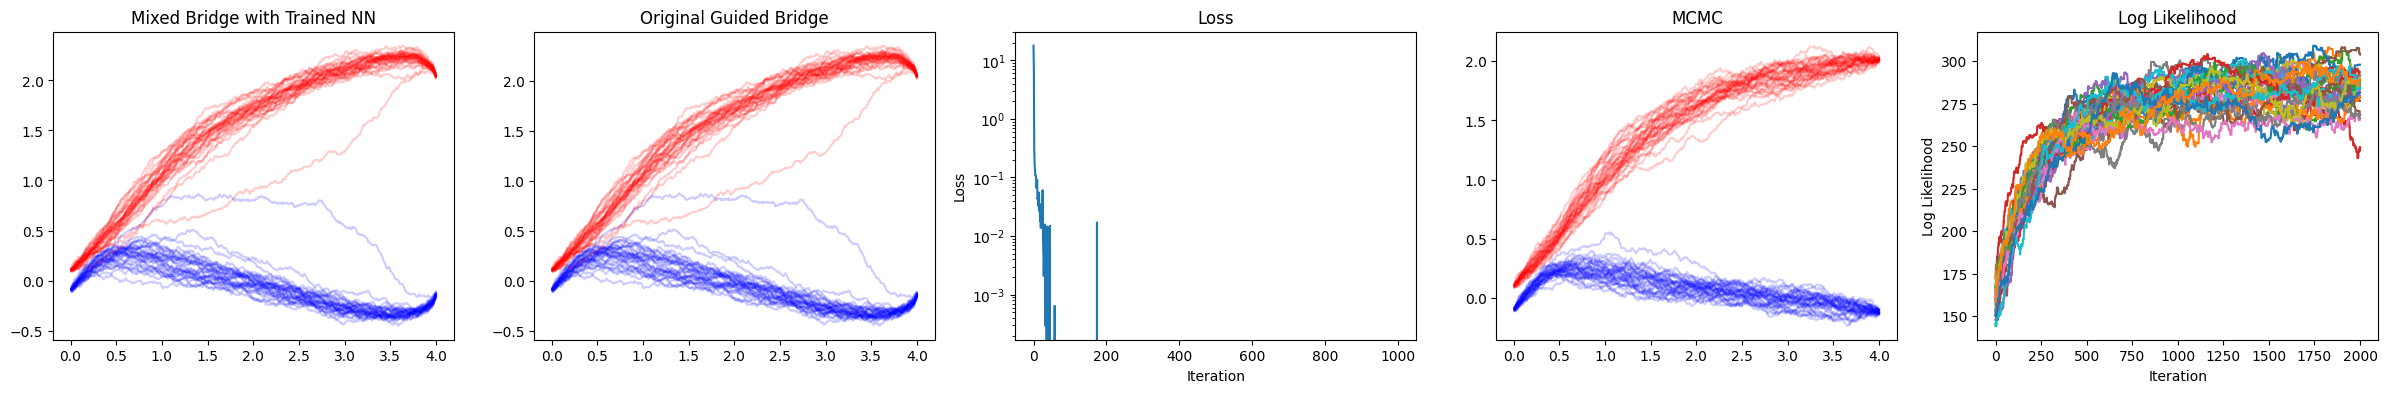

In [22]:
fig, axs = plt.subplots(1, 5, figsize=(30, 4))
for i in range(32):
    axs[0].plot(cell_mixed_bridge_path.ts, cell_mixed_bridge_path.xs[i, :, 0], color="red", alpha=0.2)
    axs[0].plot(cell_mixed_bridge_path.ts, cell_mixed_bridge_path.xs[i, :, 1], color="blue", alpha=0.2)
    axs[1].plot(cell_guided_bridge_path.ts, cell_guided_bridge_path.xs[i, :, 0], color="red", alpha=0.2)
    axs[1].plot(cell_guided_bridge_path.ts, cell_guided_bridge_path.xs[i, :, 1], color="blue", alpha=0.2)
    axs[3].plot(cell_mcmc_path.ts, cell_mcmc_path.xs[i, :, 0], color="red", alpha=0.2)
    axs[3].plot(cell_mcmc_path.ts, cell_mcmc_path.xs[i, :, 1], color="blue", alpha=0.2)
axs[2].plot(losses)
axs[2].set_xlabel("Iteration")
axs[2].set_ylabel("Loss")
axs[2].set_yscale("log")
axs[4].plot(lls)
axs[4].set_xlabel("Iteration")
axs[4].set_ylabel("Log Likelihood")
axs[0].set_title("Mixed Bridge with Trained NN")
axs[1].set_title("Original Guided Bridge")
axs[2].set_title("Loss")
axs[3].set_title("MCMC")
axs[4].set_title("Log Likelihood")
plt.show()